In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 80 (delta 44), reused 48 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 335.87 KiB | 1.33 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/InkubaLM-Challenge


In [2]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
Already up to date.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
import sys
sys.path.append("..")  # Add parent directory to the path

import os
from typing import List
from pathlib import Path
import numpy as np

# DO NOT EDIT
# create submission file
import pandas as pd
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
)
from utils import (
    eval,
    model_function,
    multitask,
    experiment_logger
    )

import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, concatenate_datasets, Dataset, Value
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import PeftModel

In [6]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [8]:
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

from huggingface_hub import login

try:
    from google.colab import userdata

    # Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
    # vars as appropriate for your system.
    # userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
except:
    os.environ["HF_TOKEN"] = "----"

login(token=os.environ["HF_TOKEN"])

token = os.environ["HF_TOKEN"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load Base Model and Fine-Tuned QLoRA model

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# 1. Load base model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    "lelapa/InkubaLM-0.4B",
    device_map="auto",
    trust_remote_code=True  # Optional, depends on model
)

tokenizer = AutoTokenizer.from_pretrained(
    "/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint"
)
tokenizer.pad_token = tokenizer.eos_token  # Important for generation

# 2. Load LoRA adapter on top of base model
model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/InkubaLM/outputs/lora_checkpoint"
)

model.eval()


config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

vulavulaslm.py:   0%|          | 0.00/42.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/lelapa/InkubaLM-0.4B:
- vulavulaslm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): VulavulaLlamaForCausalLM(
      (model): VulavulaLlamaModel(
        (embed_tokens): Embedding(61788, 2048)
        (layers): ModuleList(
          (0-7): 8 x VulavulaLlamaDecoderLayer(
            (self_attn): VulavulaLlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
        

In [15]:
print("# Loading datasets")
train_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")

print("\n# Example from training dataset:")
print(train_dataset[0])

print("\n# Example from test dataset:")
print(test_dataset[0])

# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Common Columns: ['instruction', 'langs', 'targets', 'ID', 'inputs']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

Common Columns: ['instruction', 'langs', 'targets', 'ID', 'inputs']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]


# Example from training dataset:
{'ID': 'ID_6aba33a1_sentiment_ dev_hausa', 'langs': 'hausa', 'instruction': 'Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.', 'inputs': '@user @user allah ya tsayyaba yar uwa 🎂 😍', 'targets': 'Kyakkyawa'}

# Example from test dataset:
{'ID': 'ID_f3c74c7b_sentiment_test__hausa', 'langs': 'hausa', 'instruction': "Gano ra'ayin da aka bayyana a cikin wannan rubutu. Bin waɗannan jagororin, kyakkyawa yana na rubutu na nufin kyakkyawan tunani, ɗabi'a, da motsin rai. Korau na nuna rubutu na nufin mummunan tunani ko motsin rai. Tsaka-tsaki na nuna rubutu baya nufin magana mai kyau ko mara kyau kai tsaye ko a kaikaice.", 'inputs': '@user ynxu fha da kanada kudi shikenan duk kayan nan zasu iya zama naka no🧢', 'targets': None}


## Evaluate the Current Model

Run inference analysis on the test set to measure how well the model generalises on unseen data:

In [16]:
results_df = multitask.apply_inference_to_test_data(model, tokenizer, test_dataset)
results_df.to_csv("submission_balanced.csv", index=False)


Generating Responses:   0%|          | 0/900 [00:00<?, ?it/s]

In [21]:
results_df.head()

,ID,langs,instruction,inputs,targets,generated,Response
0,ID_f3c74c7b_sentiment_test__hausa,hausa,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user ynxu fha da kanada kudi shikenan duk kay...,None,Kyakkyawan Hoto na Hoto na Hoto na Hoto na Hot...,0
1,ID_aad19dbf_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user alhamdulillah babu abinda zamuce sai god...,None,Korau Kasashen Duniya Da Kasashen Duniya Da Ka...,2
2,ID_f6de0381_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user ke ina ruwan ki 😬 ba harkar film bane ba,None,Korau: idan rubutu na nuna kyakkyawar magana k...,0
3,ID_cbec84fe_sentiment_test__swahili,swahili,Changanua mawazo ya matini yanayofuata na uain...,matokeo chanya liverais magufuli katika uzindu...,None,Wastani Wastani Wastani Wastani Wastani Wastan...,1
4,ID_885caf5c_sentiment_test__hausa,hausa,Tantance ra’ayin wannan rubutu kuma a rarraba ...,@user 🤣 akwai lauje cikin nadi gaskiya.,None,Korau Korau Korau Korau Korau Korau Kora,2


**The response column shows raw generated outputs that:**
- mix classification, translation and nonsense
- often repeat words
- sometimes echoes the prompt

**1. Identify Task Type from ID**

In [30]:
def get_task_type(row):
    if "sentiment" in row["ID"]:
        return "sentiment"
    elif "xnli" in row["ID"]:
        return "nli"
    elif "mt" in row["ID"]:
        return "mt"
    else:
        return "unknown"

results_df["task"] = results_df.apply(get_task_type, axis=1)


In [31]:
results_df

,ID,langs,instruction,inputs,targets,generated,Response,task
0,ID_f3c74c7b_sentiment_test__hausa,hausa,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user ynxu fha da kanada kudi shikenan duk kay...,None,Kyakkyawan Hoto na Hoto na Hoto na Hoto na Hot...,0,sentiment
1,ID_aad19dbf_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user alhamdulillah babu abinda zamuce sai god...,None,Korau Kasashen Duniya Da Kasashen Duniya Da Ka...,2,sentiment
2,ID_f6de0381_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user ke ina ruwan ki 😬 ba harkar film bane ba,None,Korau: idan rubutu na nuna kyakkyawar magana k...,0,sentiment
3,ID_cbec84fe_sentiment_test__swahili,swahili,Changanua mawazo ya matini yanayofuata na uain...,matokeo chanya liverais magufuli katika uzindu...,None,Wastani Wastani Wastani Wastani Wastani Wastan...,1,sentiment
4,ID_885caf5c_sentiment_test__hausa,hausa,Tantance ra’ayin wannan rubutu kuma a rarraba ...,@user 🤣 akwai lauje cikin nadi gaskiya.,None,Korau Korau Korau Korau Korau Korau Kora,2,sentiment
...,...,...,...,...,...,...,...,...
895,ID_88cd08fe_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",Bradley ya fito daga Missouri.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
896,ID_404bc9af_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Brahma ni sehemu muhimu zaidi ya utatu.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
897,ID_a399ed32_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Ilinichukua muda wa miezi 13 kukiweka kichemsh...,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0,nli
898,ID_9f28a032_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",an hada da nazarin Marxist-Leninist a harkar k...,None,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,1,nli


**2. Plot lengths of generated outputs**
- repetitive translations
- long hallucinated outputs
- tasks with very short generations (like sentiment)

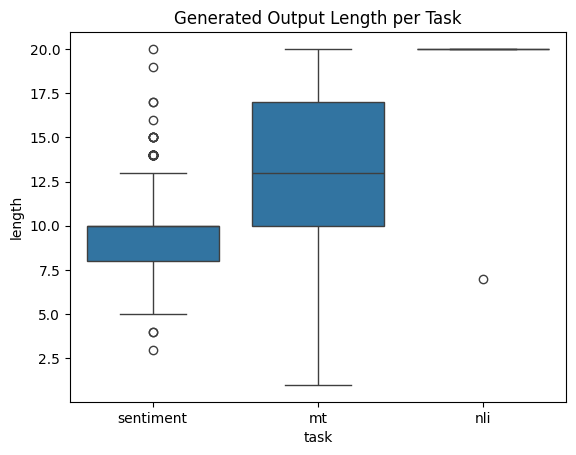

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df["length"] = results_df["generated"].str.split().apply(len)

sns.boxplot(data=results_df, x="task", y="length")
plt.title("Generated Output Length per Task")
plt.show()



**3. Check for repetitive or low-quality outputs**
- model instability or overtraining

In [33]:
repetitive = results_df[results_df["generated"].str.contains(r"\b(\w+)( \1\b){3,}", regex=True, na=False)]
print(f"Repetitive outputs: {len(repetitive)} / {len(results_df)}")



Repetitive outputs: 583 / 900


In [34]:
repetitive[["task", "inputs", "generated"]].sample(5)


,task,inputs,generated
279,sentiment,@user allah ya kiyaye wannan ba fata bane....😒...,Korau Korau Korau Korau Korau Korau Kora
880,nli,rukunin tushe yafi farashin.,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
297,sentiment,erikali imesema imedhamiria kuwanufaisha wanan...,Wastani Wastani Wastani Wastani Wastani Wastan...
44,sentiment,tafadhali tuandikie namba yako ya kadi kwa msa...,Wastani Wastani Wastani Wastani Wastani Wastan...
705,nli,ta karfaffafen tsarin kula da lafiyar maaikata...,1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2


**4. Visualise Word Frequencies (Word Cloud)**

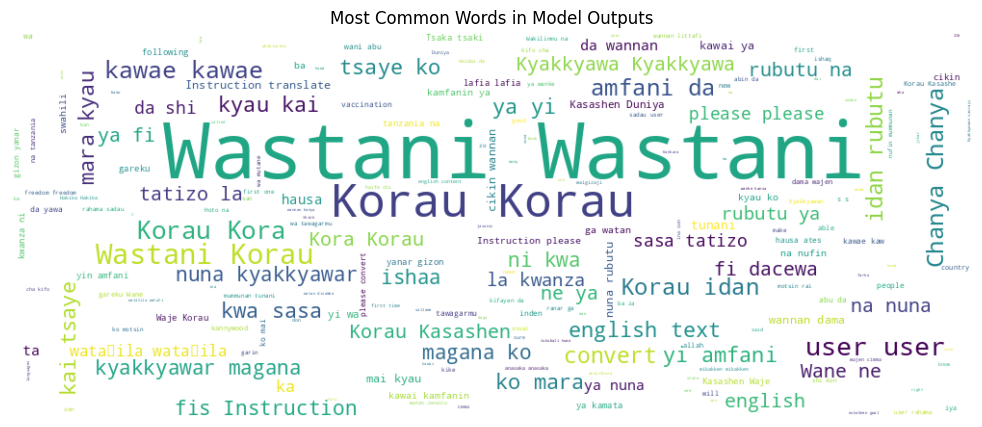

In [35]:
from wordcloud import WordCloud

text = " ".join(results_df["generated"].dropna())
wordcloud = WordCloud(width=1000, height=400, background_color="white").generate(text)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Model Outputs")
plt.show()



In [36]:
results_df["generated"].sample(10).tolist()



['Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0',
 'Korau Korau Korau Korau Korau Korau Kora',
 '1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2',
 '1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1',
 'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 'Korau: idan ba a yi wa kowa adalci ba, to a yi wa kowa adalci.',
 'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani',
 '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0']

**5. Instruction echo detection**
- prompt leakage/confusion


In [37]:
echoed_instructions = results_df[results_df["generated"].str.contains("Instruction", na=False)]
echoed_instructions[["task", "inputs", "generated"]].sample(5)



,task,inputs,generated
592,mt,i voted on the first day,i voted on the first dayevansiagawa. ### Instr...
301,mt,"i agreed to.""","i agreed to.""ishaq(r)nasiha.fis Instruction: t..."
349,mt,"when all human beings are good, there is no bl...",Wane ne ya fi dacewa a gareku?fis Instruction:...
492,mt,before the war yesterday.,Wane ne ya fi dacewa a cikin wannan littafi?fi...
378,mt,the fact that a person has held office as gove...,anyone who is not a good news?fis Instruction:...
